# Talk2KGs Agentic Tools

In this tutorial, we showcase how to invoke tools of Talk2KnowledgeGraphs via Jupiter Notebook.

As of now, the agent has the following capabilities:
- **Subgraph Extraction**: to extract a subgraph from a knowledge graph provided by the user
- **Subgraph Summarization**: to summarize a subgraph extracted from textualized subgraph obtained from the previous step
- **GraphRAG Reasoning**: to perform reasoning on a subgraph extracted from a knowledge graph by taking into account the context of the subgraph and documents provided by the user

In [30]:
# Import necessary libraries
import os
import networkx as nx
import openai 
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction import SubgraphExtractionTool
from aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization import SubgraphSummarizationTool
from aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning import GraphRAGReasoningTool

#### Set up your API key

Before following this tutorial, make sure that you set up necessary environment variables, especially the API key if you are using LLM models from OpenAI.

You can use the following options to set API key.

##### Option 1 : Retrieve API Key from Environment Variable

In [2]:
# Retrieve API key from environment variable
openai.api_key = os.getenv("OPENAI_API_KEY")

##### Option 2: Store API Key Directly in the Script (Temporary)

In [5]:
os.environ["OPENAI_API_KEY"] = "your_api_key"
# Make sure to replace "your_api_key" with your actual API key.

### SubgraphExtractionTool

Before invoking the tool, we need to define a dictionary as agent state that will be passed to the tool along with a prompt from user.

In [18]:
# Define the data path
DATA_PATH = "../../../aiagents4pharma/talk2knowledgegraphs/tests/files"

# Setup dictionary as agent state
agent_state = {
    "llm_model": "gpt-4o-mini",
    "uploaded_files": [],
    "input_tkg": f"{DATA_PATH}/kg_pyg_graph.pkl",
    "input_text_tkg": f"{DATA_PATH}/kg_text_graph.pkl",
    "topk_nodes": 3,
    "topk_edges": 3,
    "graph_dict": None,
    "graph_text": None,
    "graph_summary": None
}

# Prepare the prompt for subgraph extraction
prompt = """Extract all relevant information related to nodes of genes mentioned in the knowledge graph."""

In [19]:
# Instantiate the SubgraphExtractionTool
subgraph_extraction_tool = SubgraphExtractionTool()

In [21]:
# Invoking the subgraph_extraction_tool
result = subgraph_extraction_tool.invoke(input={"prompt": prompt, 
                                                "tool_call_id": "subgraph_extraction_tool",
                                                "state": agent_state})

INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction:Loading Hydra configuration for subgraph extraction
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction:Loading the knowledge graph (PyG Graph)
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction:Loading the knowledge graph (Textualized Graph)
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction:Preparing embedding model and embed the user prompt as query
INFO:httpx:HTTP Request: GET http://127.0.0.1:11434/api/tags "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction:Preparing the PCSTPruning object and extract the subgraph
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction:Preparing the PyTorch Geometric graph
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_extraction:Networkx DiGraph construction to be visualized in the frontend
INFO

We can check the result of the subgraph extraction tool by two approachs:
- Visualize the extracted subgraph by firstly converting the extracted subgraph to a networkx graph and then visualizing it using matplotlib.
- Print the extracted textualized subgraph.

**Subgraph Visualization**

In [26]:
def dict_to_nx_graph(graph_dict):
    """
    Convert a dictionary representation of a graph to a NetworkX graph.
    """
    # Create a directed graph
    graph = nx.DiGraph()

    # Add nodes with attributes
    for node, attrs in graph_dict["nodes"]:
        graph.add_node(node, **attrs)

    # Add edges with attributes
    for source, target, attrs in graph_dict["edges"]:
        graph.add_edge(source, target, **attrs)

    return graph

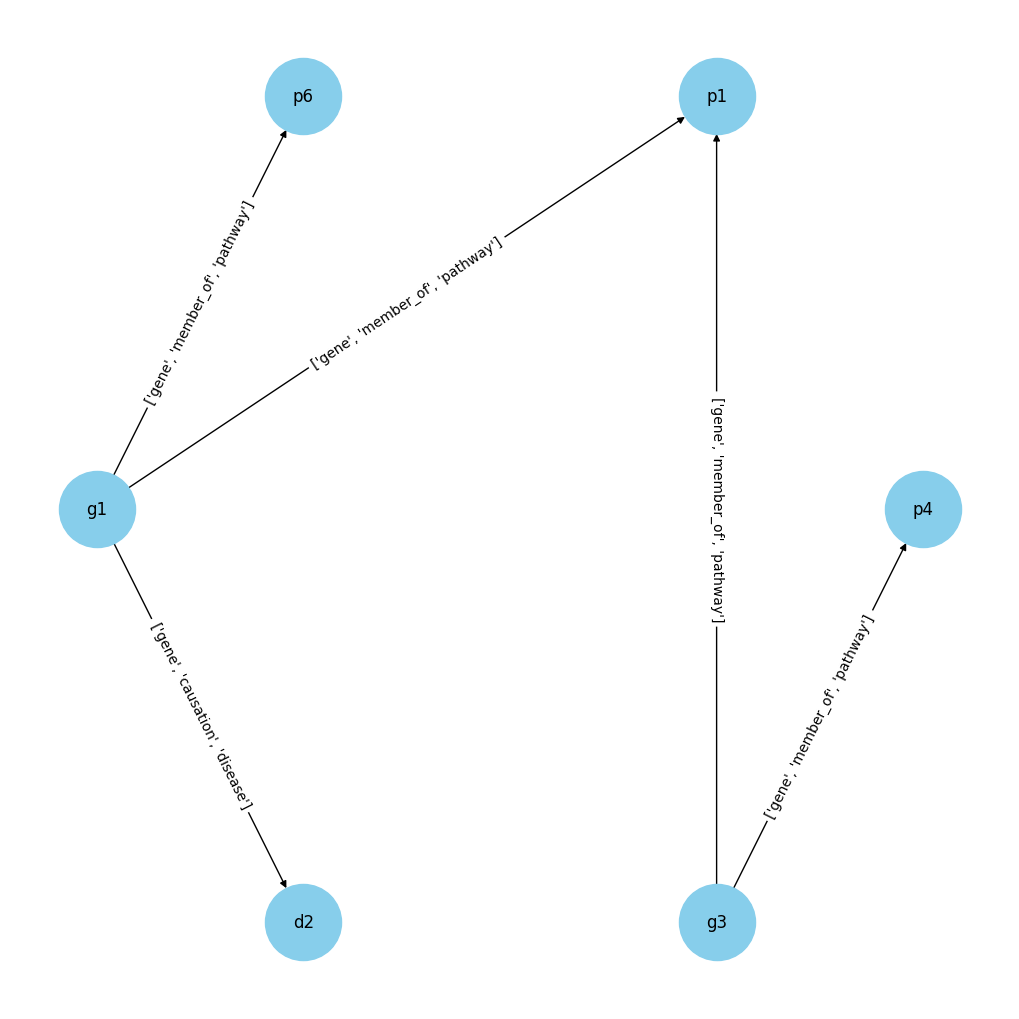

In [34]:
# Extracted subgraph 
nx_graph = dict_to_nx_graph(result.update['graph_dict'])

# Visualize the extracted subgraph
# Make a simple plot of the knowledge graph
plt.figure(figsize=(10, 10))
pos = nx.shell_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color='skyblue')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels={(u, v): d['relation'] for u, v, d in nx_graph.edges(data=True)})
plt.show()

**Textualized Subgraph Printing**

In [35]:
# Checking the result of subgraph extraction
print(result.update['graph_text'])

node_id,node_attr
g1,"NOD2 is a gene that contributes to immune responses and has been implicated in Crohn's disease, particularly through genetic mutations linked to inflammation."
d2,"Crohn disease is a type of inflammatory bowel disease that causes chronic inflammation in any part of the gastrointestinal tract, from mouth to anus, leading to symptoms like abdominal pain, diarrhea, and weight loss."
g3,TNF is a cytokine that plays a key role in systemic inflammation and is involved in the regulation of immune cells and inflammation.
p4,The IL-23 signaling pathway is a complex network of molecular interactions that regulate inflammatory responses and immune cell function.
p1,"Autophagy is a cellular process responsible for recycling and removing damaged or dysfunctional cellular components, playing a crucial role in maintaining cellular homeostasis and preventing disease."
p6,Inflammasome pathway refers to the multi-protein complexes that activate inflammatory processes through the cl

Lastly, we can store the result of the subgraph extraction in the agent state to be used in the next tutorial for subgraph summarization.

In [36]:
# Store the result of subgraph extraction
agent_state["graph_dict"] = result.update["graph_dict"]
agent_state["graph_text"] = result.update["graph_text"]

In [37]:
# Check current agent state
print(agent_state)

{'llm_model': 'gpt-4o-mini', 'uploaded_files': [], 'input_tkg': '../../../aiagents4pharma/talk2knowledgegraphs/tests/files/kg_pyg_graph.pkl', 'input_text_tkg': '../../../aiagents4pharma/talk2knowledgegraphs/tests/files/kg_text_graph.pkl', 'topk_nodes': 3, 'topk_edges': 3, 'graph_dict': {'nodes': [('g1', {}), ('d2', {}), ('g3', {}), ('p4', {}), ('p1', {}), ('p6', {})], 'edges': [('g1', 'd2', {'relation': ['gene', 'causation', 'disease'], 'label': ['gene', 'causation', 'disease']}), ('g1', 'p1', {'relation': ['gene', 'member_of', 'pathway'], 'label': ['gene', 'member_of', 'pathway']}), ('g1', 'p6', {'relation': ['gene', 'member_of', 'pathway'], 'label': ['gene', 'member_of', 'pathway']}), ('g3', 'p1', {'relation': ['gene', 'member_of', 'pathway'], 'label': ['gene', 'member_of', 'pathway']}), ('g3', 'p4', {'relation': ['gene', 'member_of', 'pathway'], 'label': ['gene', 'member_of', 'pathway']})]}, 'graph_text': 'node_id,node_attr\ng1,"NOD2 is a gene that contributes to immune responses an

### SubgraphSummarizationTool

In [ ]:
# Prepare the prompt for subgraph summarization
prompt = """You are given a subgraph in the forms of textualized subgraph representing nodes and edges (triples).
    Summarize the given subgraph and higlight the importance nodes and edges.
    """

In [38]:
# Instantiate the SubgraphSummarizationTool
subgraph_summarization_tool = SubgraphSummarizationTool()

In [39]:
# Invoking the subgraph_summarization_tool
result = subgraph_summarization_tool.invoke(input={"prompt": prompt, 
                                                   "tool_call_id": "subgraph_summarization_tool",
                                                   "state": agent_state})

INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization:Loading Hydra configuration for subgraph summarization
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization:Loading the most recent extracted subgraph
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization:Preparing prompt template
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization:Preparing LLM
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization:Using OpenAI model
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization:Preparing chain
INFO:aiagents4pharma.talk2knowledgegraphs.tools.subgraph_summarization:Invoking chain
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


We can check the result of subgraph summarization tool by printing the value of `graph_summary` key in the result.

In [40]:
# Checking the result of subgraph summarization
print(result.update['graph_summary'])

The subgraph contains relevant information about two genes: NOD2 and TNF.

1. **NOD2**:
   - **Function**: NOD2 is a gene that contributes to immune responses.
   - **Disease Association**: It has been implicated in Crohn's disease, particularly through genetic mutations that are linked to inflammation.
   - **Pathway Involvement**: NOD2 is a member of the following pathways:
     - Autophagy (p1): A cellular process that recycles and removes damaged components, crucial for maintaining cellular homeostasis.
     - Inflammasome pathway (p6): Involves multi-protein complexes that activate inflammatory processes through the cleavage of pro-inflammatory cytokines like IL-1β.

2. **TNF**:
   - **Function**: TNF is a cytokine that plays a key role in systemic inflammation and is involved in the regulation of immune cells and inflammation.
   - **Pathway Involvement**: TNF is a member of the following pathways:
     - Autophagy (p1)
     - IL-23 signaling pathway (p4): A complex network of mo

Afterward, we can store the result of subgraph summarization in the agent state to be used in the final step of the tutorial, which is reasoning.

In [41]:
# Store the result of subgraph summarization in the agent state
agent_state["graph_summary"] = result.update["graph_summary"]

In [42]:
# Check current agent state
print(agent_state)

{'llm_model': 'gpt-4o-mini', 'uploaded_files': [], 'input_tkg': '../../../aiagents4pharma/talk2knowledgegraphs/tests/files/kg_pyg_graph.pkl', 'input_text_tkg': '../../../aiagents4pharma/talk2knowledgegraphs/tests/files/kg_text_graph.pkl', 'topk_nodes': 3, 'topk_edges': 3, 'graph_dict': {'nodes': [('g1', {}), ('d2', {}), ('g3', {}), ('p4', {}), ('p1', {}), ('p6', {})], 'edges': [('g1', 'd2', {'relation': ['gene', 'causation', 'disease'], 'label': ['gene', 'causation', 'disease']}), ('g1', 'p1', {'relation': ['gene', 'member_of', 'pathway'], 'label': ['gene', 'member_of', 'pathway']}), ('g1', 'p6', {'relation': ['gene', 'member_of', 'pathway'], 'label': ['gene', 'member_of', 'pathway']}), ('g3', 'p1', {'relation': ['gene', 'member_of', 'pathway'], 'label': ['gene', 'member_of', 'pathway']}), ('g3', 'p4', {'relation': ['gene', 'member_of', 'pathway'], 'label': ['gene', 'member_of', 'pathway']})]}, 'graph_text': 'node_id,node_attr\ng1,"NOD2 is a gene that contributes to immune responses an

### GraphRAGReasoningTool

We would like to perform reasoning on the extracted subgraph and documents to answer a question.

For this purpose, we can set path to each document in the agent state.

In [43]:
# Set path to document
agent_state["uploaded_files"] = [
    {
        "file_name": "DrugA.pdf",
        "file_path": f"{DATA_PATH}/DrugA.pdf",
        "file_type": "drug_data",
        "uploaded_by": "VPEUser",
        "uploaded_timestamp": "2024-11-05 00:00:00",
    },
]

In [44]:
# Instantiate the GraphRAGReasoningTool
graphrag_reasoning_tool = GraphRAGReasoningTool()

In [45]:
# Prepare the prompt for graph reasoning
prompt = """
Perform Graph RAG reasoning to get insights related to nodes of genes mentioned in the knowledge graph related to DrugA. 

DrugA is a human monoclonal antibody that binds to both the soluble and transmembrane bioactive forms of human TNFa (UniProt Acc: P01375).
"""

In [46]:
# Invoking the graphrag_reasoning_tool
result = graphrag_reasoning_tool.invoke(input={"prompt": prompt, 
                                               "tool_call_id": "graphrag_reasoning_tool",
                                               "state": agent_state})

INFO:aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning:Loading Hydra configuration for graphrag reasoning
INFO:aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning:Preparing embeddings and LLM
INFO:aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning:Loading documents
INFO:aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning:Preparing prompt template
INFO:aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning:Chain setup
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:aiagents4pharma.talk2knowledgegraphs.tools.graphrag_reasoning:Invoking chain
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Finally, we can check the result of GraphRAG reasoning tool that taking into accounts extracted subgraph and DrugA document provided by the user.

In [52]:
# Checking the result of graph reasoning
print(result["answer"])

To perform Graph RAG reasoning regarding the genes NOD2 and TNF in relation to DrugA, we can analyze the connections and implications of these genes based on the provided context.

1. **TNF (Tumor Necrosis Factor)**:
   - **Role in Inflammation**: TNF is a key cytokine involved in systemic inflammation and immune regulation. DrugA specifically targets TNF by binding to its soluble and transmembrane forms, inhibiting its biological activity. This is particularly relevant in conditions characterized by excessive inflammation, such as rheumatoid arthritis (RA) and potentially Crohn's disease, where TNF plays a significant role.
   - **Pathway Involvement**: TNF is involved in the autophagy pathway and the IL-23 signaling pathway. By inhibiting TNF, DrugA may affect these pathways, potentially leading to reduced inflammation and altered immune responses.

2. **NOD2 (Nucleotide-binding oligomerization domain-containing protein 2)**:
   - **Function and Disease Association**: NOD2 is implica